In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas.util.testing as tm
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrices
wd = '/Users/timvigers/Dropbox/Work/Viral Shah/Day and Night CGM/'
sns.set_theme(style="whitegrid")
sns.set_palette("coolwarm")

In [3]:
# Import data
df = pd.read_csv(wd+'Data_Clean/analysis_data.csv',usecols=['HbA1c','14 Day TIR','14 Night TIR'])
df.columns = ['a1c','day_tir','night_tir']
# Get row with most sensor values for each person in JDRF data
jdrf = pd.read_csv(wd+'Data_Clean/analysis_data_jdrf.csv')
idx = jdrf.groupby('id',sort=False)['sensor_readings'].transform(max) == jdrf['sensor_readings']
jdrf = jdrf[idx]
idx = jdrf["sensor_readings"] >= 2822 # 70% cutoff for 2 weeks of data
jdrf = jdrf[idx]
# Combine
jdrf = jdrf[['a1c','day_tir','night_tir']]
df = pd.concat([df,jdrf])

# Data Characteristics
- TIR was calculated using 2 weeks of CGM data prior to an office visit.
- For participants with multiple HbA1c measures, the CGM wear with the largest number of sensor readings was used. This was done to prevent auto-correlation between measures within a subject.
- CGM with < 70% wear were excluded.
- HbA1c was split into the following quintiles: (4.899, 6.2] < (6.2, 6.7] < (6.7, 7.3] < (7.3, 8.0] < (8.0, 13.5]

In [4]:
# Split into quintiles
df['a1c_group'] = pd.qcut(df['a1c'],5)
# Difference between day and night TIR
df['tir_diff'] = df['day_tir'] - df['night_tir']

## Mean Day and Night TIR

### Full Cohort

#### Means

In [5]:
means = df.mean(axis=0,numeric_only=True)
means.index = ['Mean HbA1c','Mean Day TIR','Mean Night TIR','Mean Day vs. Night TIR Difference']
means

Mean HbA1c                            7.218072
Mean Day TIR                         60.518396
Mean Night TIR                       58.339010
Mean Day vs. Night TIR Difference     2.179386
dtype: float64

#### Standard Errors

In [6]:
sem = df.sem(axis=0,numeric_only=True)
sem.index = ['SE HbA1c','SE Day TIR','SE Night TIR','SE Day vs. Night TIR Difference']
sem

SE HbA1c                           0.074872
SE Day TIR                         1.054510
SE Night TIR                       1.216089
SE Day vs. Night TIR Difference    0.745464
dtype: float64

### By HbA1c Quintile

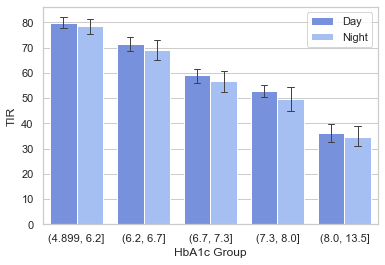

In [7]:
# Wide to long
plot_df = df.melt(id_vars=['a1c','a1c_group'],value_vars=['day_tir','night_tir'], value_name='TIR')
plot_df['variable'].replace({'day_tir':'Day','night_tir':'Night'},inplace=True)
# Plot
plot = sns.barplot(x='a1c_group',y='TIR',hue='variable',data=plot_df,capsize=.1,errwidth=1)
plot.set(xlabel='HbA1c Group')
plot.legend(title='');

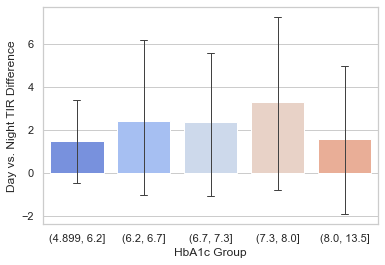

In [8]:
plot = sns.barplot(x='a1c_group',y='tir_diff',data=df,capsize=.1,errwidth=1)
plot.set(xlabel='HbA1c Group',ylabel='Day vs. Night TIR Difference');

Error bars indicate 95% confidence interval around the mean.

#### Means

In [9]:
means = df.groupby(['a1c_group']).mean().drop('a1c', axis=1)
means.columns = ['Mean Day TIR','Mean Night TIR','Mean Day vs. Night TIR Difference']
sem = df.groupby(['a1c_group']).sem().drop('a1c', axis=1)
sem.columns = ['SE Day TIR','SE Night TIR','SE Day vs. Night TIR Difference']
means

,Mean Day TIR,Mean Night TIR,Mean Day vs. Night TIR Difference
a1c_group,,,
"(4.899, 6.2]",79.845783,78.377183,1.468600
"(6.2, 6.7]",71.287413,68.885929,2.401484
"(6.7, 7.3]",59.013201,56.663401,2.349800
"(7.3, 8.0]",52.797887,49.532942,3.264945
"(8.0, 13.5]",36.228310,34.668662,1.559649


#### Standard Errors

In [10]:
sem

,SE Day TIR,SE Night TIR,SE Day vs. Night TIR Difference
a1c_group,,,
"(4.899, 6.2]",1.150486,1.491957,1.000227
"(6.2, 6.7]",1.400028,1.978346,1.856595
"(6.7, 7.3]",1.438321,2.046857,1.716620
"(7.3, 8.0]",1.347229,2.411797,1.948089
"(8.0, 13.5]",1.882273,2.017976,1.838249


There were significant differences in day TIR and night TIR by HbA1c quintile (p < 0.001 for both). However, the difference between day and night TIR was not different between HbA1c quintiles (p = 0.95).

## Correlation between HbA1c and TIR

### Full Cohort

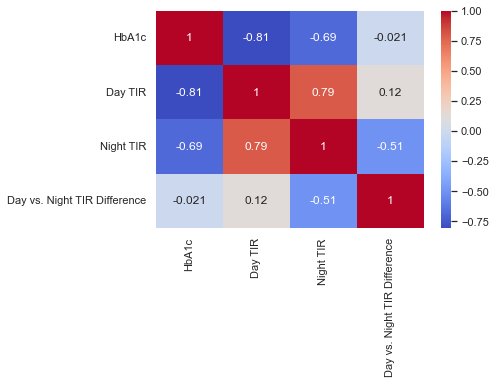

In [11]:
corr_mat = df
corr_mat.columns = ['HbA1c','Day TIR','Night TIR','HbA1c Group','Day vs. Night TIR Difference']
c_full = corr_mat.corr()
sns.heatmap(c_full,annot=True,cmap="coolwarm");

### By HbA1c Quintile

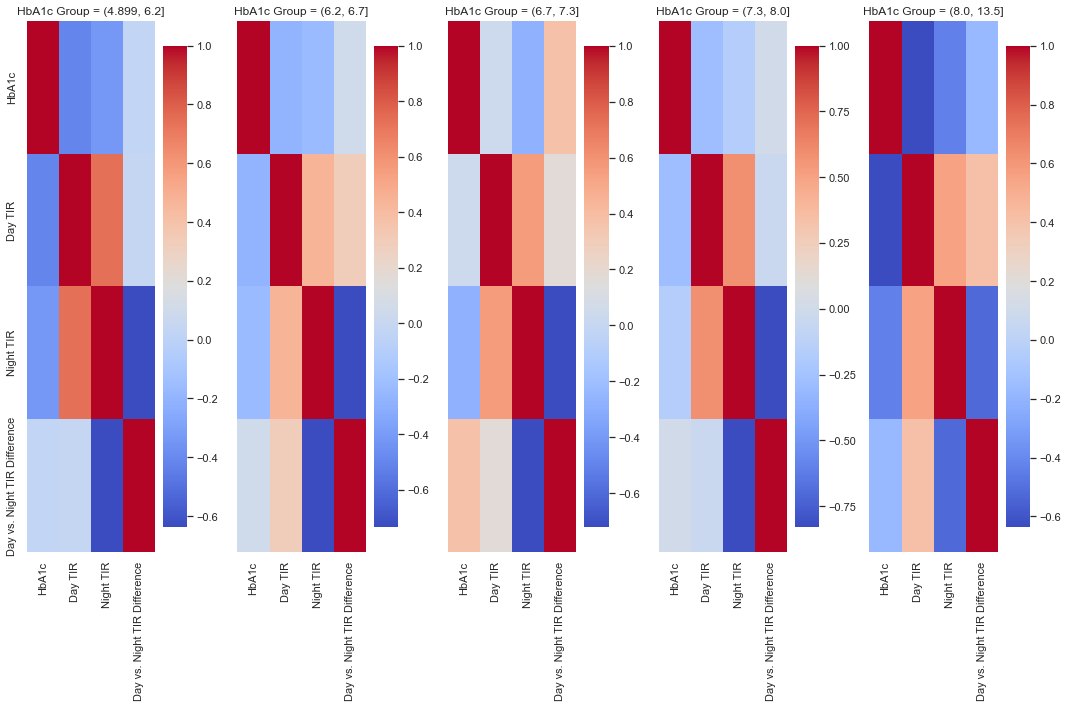

In [12]:
g = sns.FacetGrid(corr_mat, col='HbA1c Group')
g.fig.set_figwidth(15)
g.fig.set_figheight(10)
g.map_dataframe(lambda data, color: sns.heatmap(data.corr(),cmap="coolwarm"));

In [13]:
corr_mat.groupby('HbA1c Group').corr()

HbA1c   Day TIR  Night TIR  \
HbA1c Group                                                                
(4.899, 6.2] HbA1c                         1.000000 -0.419184  -0.342278   
             Day TIR                      -0.419184  1.000000   0.742539   
             Night TIR                    -0.342278  0.742539   1.000000   
             Day vs. Night TIR Difference  0.028392  0.042641  -0.637531   
(6.2, 6.7]   HbA1c                         1.000000 -0.275166  -0.237927   
             Day TIR                      -0.275166  1.000000   0.438125   
             Night TIR                    -0.237927  0.438125   1.000000   
             Day vs. Night TIR Difference  0.046031  0.287227  -0.735194   
(6.7, 7.3]   HbA1c                         1.000000  0.042071  -0.282767   
             Day TIR                       0.042071  1.000000   0.562426   
             Night TIR                    -0.282767  0.562426   1.000000   
             Day vs. Night TIR Difference  0.372415  0.167256  -0.721131   
(7.3, 8.0]   HbA1c                         1.000000 -0.283288  -0.162617   
             Day TIR                      -0.283288  1.000000   0.590405   
             Night TIR                    -0.162617  0.590405   1.000000   
             Day vs. Night TIR Difference  0.005413 -0.039376  -0.829729   
(8.0, 13.5]  HbA1c                         1.000000 -0.636129  -0.436907   
             Day TIR                      -0.636129  1.000000   0.557609   
             Night TIR                    -0.436907  0.557609   1.000000   
             Day vs. Night TIR Difference -0.171740  0.411822  -0.526808   

                                           Day vs. Night TIR Difference  
HbA1c Group                                                              
(4.899, 6.2] HbA1c                                             0.028392  
             Day TIR                                           0.042641  
             Night TIR                                        -0.637531  
             Day vs. Night TIR Difference                      1.000000  
(6.2, 6.7]   HbA1c                                             0.046031  
             Day TIR                                           0.287227  
             Night TIR                                        -0.735194  
             Day vs. Night TIR Difference                      1.000000  
(6.7, 7.3]   HbA1c                                             0.372415  
             Day TIR                                           0.167256  
             Night TIR                                        -0.721131  
             Day vs. Night TIR Difference                      1.000000  
(7.3, 8.0]   HbA1c                                             0.005413  
             Day TIR                                          -0.039376  
             Night TIR                                        -0.829729  
             Day vs. Night TIR Difference                      1.000000  
(8.0, 13.5]  HbA1c                                            -0.171740  
             Day TIR                                           0.411822  
             Night TIR                                        -0.526808  
             Day vs. Night TIR Difference                      1.000000